In [1]:
import numpy as np
import os
import pandas as pd
import re
import gc 
import random
import os
from random import shuffle
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', None)

In [2]:
def df_to_np(df): #convert df to np array, seperate labels and attack
    X = df.iloc[:,0:-2].to_numpy()
    y = df.iloc[:,-2:].to_numpy()
    return X, y

def seperate_label_attack(y):
    a = y[:,0]
    y = np.asarray(y[:,1]).astype('int8')
    return y, a

def split_train_val(df, val_ratio):
    df_val = df[df['Attack']=='Benign'].sample(frac=(val_ratio))
    df_val = pd.concat([df_val, df[df['Attack']!='Benign'].sample(frac=(val_ratio))], axis=0)
    df.drop(df_val.index, inplace=True)
    return df, df_val

def bgta_ub(df, attacks, r): #benign count gt anomaly count
    try:
        df_tr = df[df['Label']==1]
        total_benign = int(round(len(df_tr.index)/(1-r))*(r))
        df_tr = pd.concat([df_tr, df[df['Label'] == 0].sample(n=total_benign)], axis=0)
    except:
        df_tr = pd.DataFrame()
        for attack in attacks:
            df_tr = pd.concat([df_tr, df[df['Attack'] == attack].sample(frac=0.5)], axis=0)
        n_ben = len(df_tr.index)
        df_tr = pd.concat([df_tr, df[df['Label'] == 0].sample(n=round((len(df_tr.index))/(1-r)))], axis=0)
    df.drop(df_tr.index, inplace=True)
    return df, df_tr

def agtb_ub(df, attacks, r): #benign count gt anomaly count
    tot_dist = df['Label'].value_counts()
    df_tr = df[df['Label']==0]
    total_anomaly = int(round(len(df_tr.index)/r)*(1-r))
    f = total_anomaly/(tot_dist[1])
    for attack in attacks:
        df_tr = pd.concat([df_tr, df[df['Attack'] == attack].sample(frac=f)], axis=0)
    df.drop(df_tr.index, inplace=True)
    return df, df_tr

def unbalance_train(df, r):
    attacks = df[df['Attack'] != 'Benign']['Attack'].unique()
    value_c = df[df['Attack'] != 'Benign']['Attack'].value_counts()
    tot_dist = df['Label'].value_counts()
    if tot_dist[0] > tot_dist[1]:
        df, df_tr = bgta_ub(df, attacks, r)
    else:
        df, df_tr = agtb_ub(df, attacks, r)
    return df, df_tr

## Configurables

In [3]:
#                      0              1                              2                 3
files = ['CNF-BoT-IoT-v2.csv', 'CNF-CSE-CIC-IDS2018-v2.csv', 'CNF-ToN-IoT-v2b.csv', 'CNF-UNSW-NB15-v2.csv'] #CNB15-syntheticddos

isolate = 1
r=0.5 #benign to anomaly ratio for train, val sets
r_t = 0.5 #benign to anomaly ratio for test set
test_ratio = 0.25
folder= 'oboa/'
dir = '../../../Datasets/NF-UQ-NIS-2/' #original dataset directory
rboa_new_test_file = 'rboa/rb_r5_CNF-CSE-CIC-IDS2018-v2.csv'

d = {#'L4_SRC_PORT': np.int32,
    'L4_DST_PORT': np.int32,
    'PROTOCOL': np.int32,
    'L7_PROTO': np.float64,
    'IN_BYTES': np.int32,
    'IN_PKTS': np.int32,
    'OUT_BYTES': np.int32,
    'OUT_PKTS': np.int32,
    'TCP_FLAGS': np.int32,
    'CLIENT_TCP_FLAGS': np.int32,
    'SERVER_TCP_FLAGS': np.int32,
    'FLOW_DURATION_MILLISECONDS': np.int32,
    'DURATION_IN': np.int32,
    'DURATION_OUT': np.int32,
    'MIN_TTL': np.int32,
    'MAX_TTL': np.int32,
    'LONGEST_FLOW_PKT': np.int32,
    'SHORTEST_FLOW_PKT': np.int32,
    'MIN_IP_PKT_LEN': np.int32,
    'MAX_IP_PKT_LEN': np.int32,
# 'SRC_TO_DST_SECOND_BYTES': np.float64,
# 'DST_TO_SRC_SECOND_BYTES': np.float64,
#  'RETRANSMITTED_IN_BYTES': np.int32,
#  'RETRANSMITTED_IN_PKTS': np.int32,
#  'RETRANSMITTED_OUT_BYTES': np.int32,
#  'RETRANSMITTED_OUT_PKTS': np.int32,
#  'SRC_TO_DST_AVG_THROUGHPUT': np.int32,
#  'DST_TO_SRC_AVG_THROUGHPUT': np.int32,
#  'NUM_PKTS_UP_TO_128_BYTES': np.int32,
#  'NUM_PKTS_128_TO_256_BYTES': np.int32,
#  'NUM_PKTS_256_TO_512_BYTES': np.int32,
#  'NUM_PKTS_512_TO_1024_BYTES': np.int32,
#  'NUM_PKTS_1024_TO_1514_BYTES': np.int32,
    'TCP_WIN_MAX_IN': np.int32,
    'TCP_WIN_MAX_OUT': np.int32,
    'ICMP_TYPE': np.int32,
    'ICMP_IPV4_TYPE': np.int32,
    'DNS_QUERY_ID': np.int32,
    'DNS_QUERY_TYPE': np.int32,
    'DNS_TTL_ANSWER': np.int32,
    'FTP_COMMAND_RET_CODE': np.float64
    }

headers = list(d.keys())
print('Selected # of features: {0}'.format(len(headers)))
headers.extend(('Attack', 'Label'))

print('Isolating: {0}'.format(files[isolate]))
isolated = files[isolate]
files.pop(isolate)
print(files)

Selected # of features: 27
Isolating: CNF-CSE-CIC-IDS2018-v2.csv
['CNF-BoT-IoT-v2.csv', 'CNF-ToN-IoT-v2b.csv', 'CNF-UNSW-NB15-v2.csv']


## Generate Train and Validation Data

In [4]:
pd.DataFrame(columns=headers).to_csv(folder+'/3_train.csv', header=True, index=None)
pd.DataFrame(columns=headers).to_csv(folder+'/3_test.csv', header=True, index=None)
pd.DataFrame(columns=headers).to_csv(folder+'/3_ph.csv', header=True, index=None)
pd.DataFrame(columns=headers).to_csv(folder+'/3_lo.csv', header=True, index=None)
pd.DataFrame(columns=headers).to_csv(folder+'/3_lof.csv', header=True, index=None)
    
for file in files:
    print('Processing {0}'.format(file))
    df_te = pd.read_csv(dir+file, usecols=['Label','Attack'])
    print('Balancing data')
    df_te, df_tr = unbalance_train(df_te, r)
    print('Total Benign Data used for train & val:{0}'.format((len(df_tr[df_tr['Label']==0].index))))
    print('Total Attack Data used for train & val:{0}'.format((len(df_tr[df_tr['Label']==1].index))))
    
    te_index = df_te.index.to_list()
    tr_index = df_tr.index.to_list()

    #clear up memory in RAM
    del df_tr
    del df_te
    gc.collect()
    df_tr = pd.DataFrame()
    df_te = pd.DataFrame()
    
    #save to file
    print('Saving files for {0}'.format(file))
    for chunk in pd.read_csv(dir+file, usecols=headers, dtype=d, chunksize=10000000, iterator=True):
        chunk.loc[[n for n in tr_index if n in range(chunk.index.start,chunk.index.stop)]].to_csv(folder+'3_ph.csv', mode = 'a', header=None, index=0)
        chunk.loc[[n for n in te_index if n in range(chunk.index.start,chunk.index.stop)]].to_csv(folder+'3_lo.csv', mode = 'a', header=None, index=0)

Processing CNF-BoT-IoT-v2.csv
Balancing data
Total Benign Data used for train & val:132316
Total Attack Data used for train & val:132316
Saving files for CNF-BoT-IoT-v2.csv
Processing CNF-ToN-IoT-v2b.csv
Balancing data
Total Benign Data used for train & val:2702185
Total Attack Data used for train & val:2702184
Saving files for CNF-ToN-IoT-v2b.csv
Processing CNF-UNSW-NB15-v2.csv
Balancing data
Total Benign Data used for train & val:58677
Total Attack Data used for train & val:58677
Saving files for CNF-UNSW-NB15-v2.csv


## Add leftover data to training set

Generating test set. below is leftover data


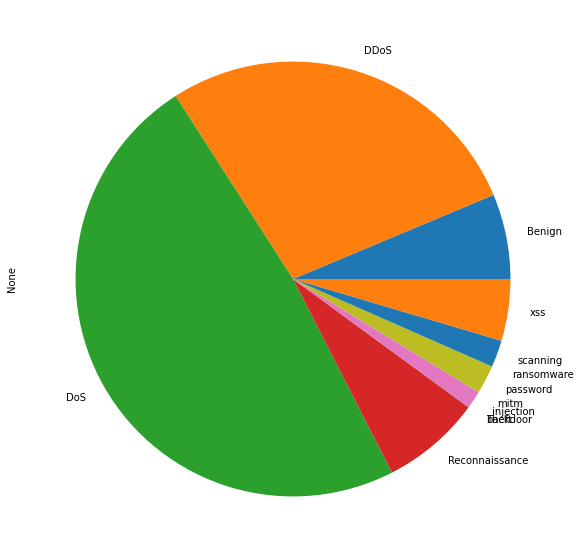

Attack
Benign             2219842
DDoS               9746688
DoS               17012243
Reconnaissance     2607066
Theft                 2123
backdoor             11108
injection           450730
mitm                  5011
password            743382
ransomware            2203
scanning            704957
xss                1610961
dtype: int64

Saving Files
Deleting old leftover file and clearing memory


3443

In [5]:
print('Generating test set. below is leftover data')
df_lo = pd.read_csv(folder+'3_lo.csv', usecols=['Label','Attack'])

count_series = df_lo.groupby(['Attack']).size()
count_series.plot(kind='pie', figsize=(10,10))
plt.show()
print(count_series)

df_lo, df_te = unbalance_train(df_lo, r)

lof_index = df_lo.index.to_list()
te_index = df_te.index.to_list()

print('\nSaving Files')
for chunk in pd.read_csv(folder+'3_lo.csv', dtype=d, chunksize=10000000, iterator=True):
        chunk.loc[[n for n in lof_index if n in range(chunk.index.start,chunk.index.stop)]].to_csv(folder+'3_lof.csv', mode = 'a', header=None, index=0)
        chunk.loc[[n for n in te_index if n in range(chunk.index.start,chunk.index.stop)]].to_csv(folder+'3_ph.csv', mode = 'a', header=None, index=0)

        
print('Deleting old leftover file and clearing memory')        
os.remove(folder+'3_lo.csv')

del df_te
del df_lo
gc.collect()


In [6]:
df = pd.read_csv(folder+'3_ph.csv', usecols=['Label','Attack'])
df, df_te = split_train_val(df, test_ratio)

tr_index = df.index.to_list()
te_index = df_te.index.to_list()

print('\nSaving Files')
for chunk in pd.read_csv(folder+'3_ph.csv', dtype=d, chunksize=10000000, iterator=True):
        chunk.loc[[n for n in tr_index if n in range(chunk.index.start,chunk.index.stop)]].to_csv(folder+'3_train.csv', mode = 'a', header=None, index=0)
        chunk.loc[[n for n in te_index if n in range(chunk.index.start,chunk.index.stop)]].to_csv(folder+'3_test.csv', mode = 'a', header=None, index=0)

        
print('Deleting old leftover file and clearing memory')        
os.remove(folder+'3_ph.csv')

del df
del df_te
gc.collect()


Saving Files
Deleting old leftover file and clearing memory


0

## Breakdown of all generated files

3_train.csv

p: 0.5000000651930516


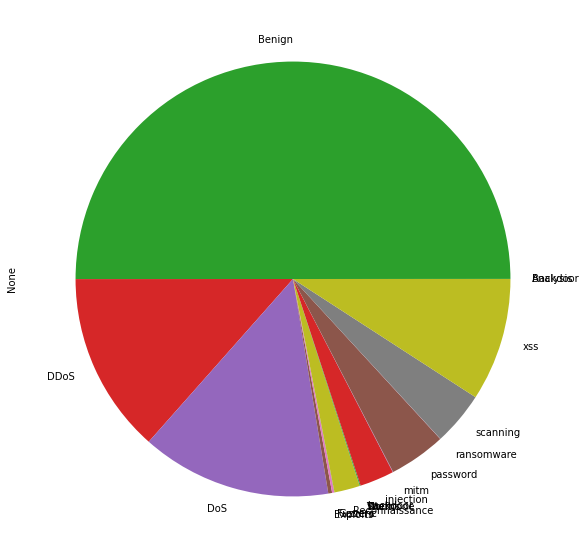

Attack
Analysis              297
Backdoor              257
Benign            3834765
DDoS              1031578
DoS               1084569
Exploits            21714
Fuzzers             11341
Generic              2246
Reconnaissance     145881
Shellcode             532
Theft                 118
Worms                 108
backdoor             4851
injection          196138
mitm                 2215
password           323834
ransomware            969
scanning           306599
xss                701517
dtype: int64

-------------------------------------
3_test.csv

p: 0.5


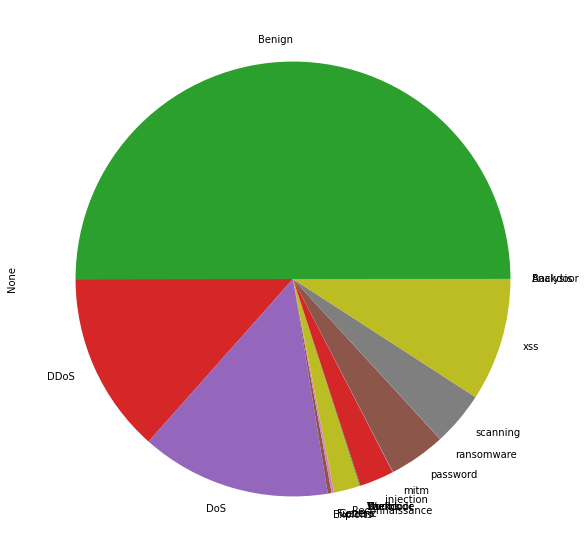

Attack
Analysis               83
Backdoor               84
Benign            1278255
DDoS               343503
DoS                360962
Exploits             7233
Fuzzers              3965
Generic               768
Reconnaissance      49023
Shellcode             179
Theft                  35
Worms                  35
backdoor             1598
injection           65549
mitm                  694
password           107763
ransomware            310
scanning           102688
xss                233783
dtype: int64

-------------------------------------
3_lof.csv

p: 0.0


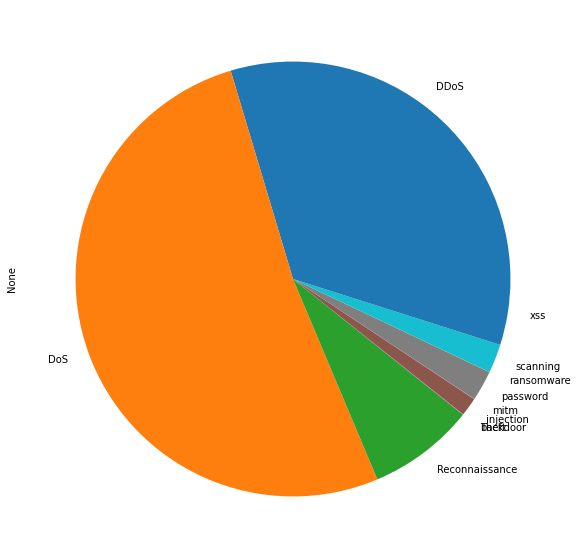

Attack
DDoS               9088985
DoS               15864263
Reconnaissance     2431142
Theft                 1980
backdoor             10358
injection           420315
mitm                  4673
password            693219
ransomware            2054
scanning            657387
xss                1502254
dtype: int64

-------------------------------------


In [7]:
files = ['3_train.csv', '3_test.csv', '3_lof.csv']
for file in files:
    print(file+'\n')
    df = pd.read_csv(folder+file, usecols=['Label','Attack'])
    print('p:', str(len(df[df['Label'] == 0].index)/len(df.index)))   
    count_series = df.groupby(['Attack']).size()
    count_series.plot(kind='pie', figsize=(10,10))
    plt.show()
    print(count_series)
    print('\n-------------------------------------')
    del df
    gc.collect()

## Scale Train, Validation and Test Sets

In [8]:
print('Generating training data numpy arrays')
X, y = df_to_np(pd.read_csv(folder+'3_train.csv', dtype=d).sample(frac=1))
y, a = seperate_label_attack(y)
np.save(folder+'X_train.npy', X)
np.save(folder+'y_train.npy', y)

print('Generating test data numpy arrays')
X, y = df_to_np(pd.read_csv(folder+'3_test.csv', dtype=d).sample(frac=1))
y, a = seperate_label_attack(y)
np.save(folder+'X_test.npy', X)
np.save(folder+'y_test.npy', y)
        
del X
del y
del a
gc.collect()

Generating training data numpy arrays
Generating test data numpy arrays


0

## Generate Final Test Set with number of benign samples equal to RBOA
If Error, run RBOA preprocess script and return. Ensure RBOA r value is the same

Generating test 2 data numpy arrays
p: 0.8233854826224172


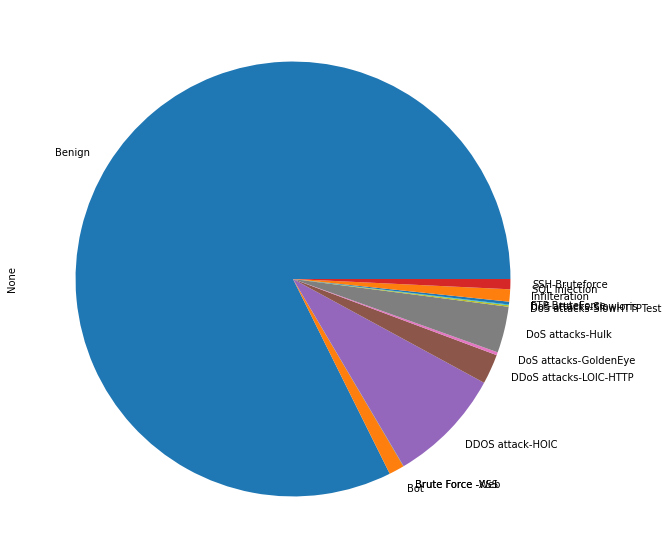

Attack
Benign                      10370746
Bot                           143097
Brute Force -Web                2094
Brute Force -XSS                 895
DDOS attack-HOIC             1080858
DDoS attacks-LOIC-HTTP        280337
DoS attacks-GoldenEye          27723
DoS attacks-Hulk              432487
DoS attacks-SlowHTTPTest       14116
DoS attacks-Slowloris           7227
FTP-BruteForce                 25933
Infilteration                 114326
SQL Injection                    432
SSH-Bruteforce                 94979
dtype: int64
p: 0.8233854826224172


In [11]:
isolated = rboa_new_test_file
print('Generating test 2 data numpy arrays')
df = pd.read_csv(isolated, dtype=d, usecols=headers)
print('p:', str(len(df[df['Label'] == 0].index)/len(df.index)))
count_series = df.groupby(['Attack']).size()
count_series.plot(kind='pie', figsize=(10,10))
plt.show()
print(count_series)
print('p:', str(len(df[df['Label'] == 0].index)/len(df.index)))
X_1_ar, y_1_ar = df_to_np(df)
y_1_ar, a_1_ar = seperate_label_attack(y_1_ar)

np.save(folder+'X_1.npy', X_1_ar)
np.save(folder+'y_1.npy', y_1_ar)
np.save(folder+'a_1.npy', a_1_ar)

## Final Test Set with attacks not expected to be detected removed

Generating test 2 data numpy arrays
p: 0.9350631388199289


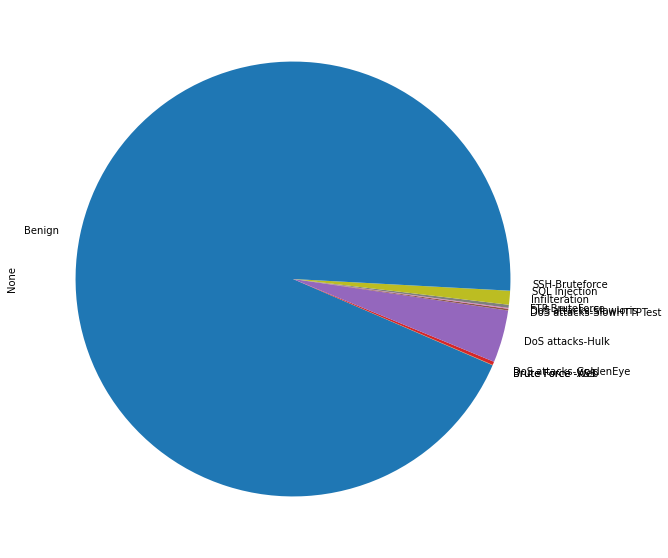

Attack
Benign                      10370746
Brute Force -Web                2094
Brute Force -XSS                 895
DoS attacks-GoldenEye          27723
DoS attacks-Hulk              432487
DoS attacks-SlowHTTPTest       14116
DoS attacks-Slowloris           7227
FTP-BruteForce                 25933
Infilteration                 114326
SQL Injection                    432
SSH-Bruteforce                 94979
dtype: int64


7045

In [12]:
print('Generating test 2 data numpy arrays')
df = pd.read_csv(isolated, dtype=d, usecols=headers)
df.drop(df[df['Attack'] == 'DDOS attack-HOIC'].sample(frac=1).index, inplace=True)
df.drop(df[df['Attack'] == 'DDoS attacks-LOIC-HTTP'].sample(frac=1).index, inplace=True)
df.drop(df[df['Attack'] == 'DDOS attack-LOIC-UDP'].sample(frac=1).index, inplace=True)
df.drop(df[df['Attack'] == 'Bot'].sample(frac=1).index, inplace=True)
print('p:', str(len(df[df['Label'] == 0].index)/len(df.index)))
count_series = df.groupby(['Attack']).size()
count_series.plot(kind='pie', figsize=(10,10))
plt.show()
print(count_series)

X_1_ar, y_1_ar = df_to_np(df)
y_1_ar, a_1_ar = seperate_label_attack(y_1_ar)

np.save(folder+'X_1_ar.npy', X_1_ar)
np.save(folder+'y_1_ar.npy', y_1_ar)
np.save(folder+'a_1_ar.npy', a_1_ar)


del X_1_ar
del y_1_ar
del a_1_ar
del df
gc.collect()